In [1]:
using Symbolics, FastGaussQuadrature, Plots, QuadGK, LinearAlgebra, Revise

#Define Piecewise Linear Functions
function Na(x, mesh, index, delta)
    if x < 0 #Handle Gauss-legendre
        return 0
    end
    if index == 1 #Edge case handling
        if x < mesh[index+1]
            u = (mesh[index+1] - x)/ delta
            return u
        else
            return 0
        end
    elseif x < mesh[index-1] #Note: Index must be greated than 2
        return 0
    elseif x < mesh[index] # Piece from NA-1 to NA
        return (x - mesh[index-1]) / (delta)
    elseif x < mesh[index+1]
        return (mesh[index+1] - x) / (delta)
    else
        return 0
    end
end

function Naprime(x, mesh, index, delta)
    if x < 0 #Handle Gauss-legendre
        return 0
    end
    if index == 1 #Edge case handling
        if x < mesh[index+1]
            u = (- 1)/ delta
            return u
        else
            return 0
        end
    elseif x < mesh[index-1] #Note: Index must be greated than 2
        return 0
    elseif x < mesh[index] # Piece from NA-1 to NA
        return (1) / (delta)
    elseif x < mesh[index+1]
        return (-1) / (delta)
    else
        return 0
    end
end

function Nmax(x, mesh, delta)    
    if x < 0#Handle Gauss-legendre
        return 0
    elseif x < mesh[length(mesh)-1]
        return 0
    else
        u = (x - mesh[length(mesh)-1])/delta
        return u
    end
end

function Nmaxprime(x, mesh, delta)    
    if x < 0#Handle Gauss-legendre
        return 0
    elseif x < mesh[length(mesh)-1]
        return 0
    else
        u = (1)/delta
        return u
    end
end

function construct_K_elem(a, k, mesh, row, col, delta)
    #Using sym
    x, t = gausslegendre(100); #integrates from -1 to 1 but all basis functions are 0 for x < 0
    #(k*w_x*u_x) - (a*w_x*u)
    f(x) = k * Naprime(x, mesh, row, delta) * Naprime(x, mesh, col, delta) - a * Naprime(x, mesh, row, delta) * Na(x, mesh, col, delta)
    #Book example
    #f(x) = k * Naprime(x, mesh, row, delta) * Naprime(x, mesh, col, delta)# - a * Naprime(x, mesh, col, delta) * Na(x, mesh, row, delta)
    #f(x) = k * Naprime(x, mesh, row, delta) * Naprime(x, mesh, col, delta) - a * Na(x, mesh, row, delta) * Naprime(x, mesh, col, delta)
    I = dot(t, f.(x));
    return I
end

function construct_F_elem(a, k, mesh, row, delta, boundaries)
    x, t = gausslegendre(100)
    #ADR Eqn
    f(x) = Na(x, mesh, row, delta) * 12*x^2 #- a*Naprime(x, mesh, row, delta)*Nmax(x, mesh, delta) + k*Naprime(x, mesh, row, delta)*Nmaxprime(x, mesh, delta)
    #Book Example
    #f(x) = a*Naprime(x, mesh, row, delta)*Nmax(x, mesh, delta)
    I = dot(t, f.(x))
    #print("row: ", row, "F: ", I, "\n")
    return I
    #end
end

function construct_K(a, k, mesh, numrow, numcol, delta)
    KMat = zeros(numrow, numcol)
    for i = 1:numrow
        for j = 1:numcol
            KMat[i, j] = construct_K_elem(a, k, mesh, i, j, delta)
        end
    end
    return KMat
end

function construct_F(a, k, mesh, numrow, delta)
    FVec = zeros(numrow)
    for i = 1:numrow
        FVec[i] = construct_F_elem(a, k, mesh, i, delta, [0,1])
    end
    return FVec
end

function ADR_galerkin(n::Int, a::Float64, k::Float64, boundaries)
    @variables x
    t = 0:.01:1
    delta = 1. / (n)
    mesh = collect(0:(1. / (n)):1) #n+1 points for n subintervals; x1 = 0; x_n+1 = 1
    d = construct_F(a, k, mesh, n, delta) \ construct_K(a,k, mesh, n, n, delta)
    sum = zeros(length(t))
    f(x, y::Int) = d[y]*Na(x, mesh, y, delta)
    for i=1:1:n
        sum+=f.(t, i)
    end
    fn1(x) = Nmax(x, mesh, delta)
    sum += fn1.(t)
    print("\n1D Uniform Mesh: ", mesh, " with spacing: ", delta, "\n")
    print("\nCoefficients: ", d,"\n")
    plot(t, sum)
    #plot(d)
    #f(x) = dot(d, Na) #d[1]*Na(x, mesh, 1, delta) + d[2]*Na(x, mesh, 2, delta) + d[3]*Na(x, mesh, 3, delta) + d[4]*Na(x, mesh, 4, delta) + d[5]*Na(x, mesh, 5, delta) + d[6]*Na(x, mesh, 6, delta) + d[7]*Na(x, mesh, 7, delta) + d[8]*Na(x, mesh, 8, delta) #+ Nmax(x, mesh, delta)
    #plot(uh, xlim=(0,1), title="h-1 = $n, Peclet = $a/$k")
end

ADR_galerkin (generic function with 1 method)


1D Uniform Mesh: [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0] with spacing: 0.0625

Coefficients: [-0.034447303881306277 -0.06173535503079079 -0.0670557818495855 -0.06836156214512923 -0.06788642695223457 -0.06498812252326358 -0.14520860297770755 -0.12079156186465356 0.07606950858115269 -0.43675086148036346 0.3443026247049277 -0.320948657411007 -0.1283191886223385 -0.07039745481357862 -0.18798143823029534 7.864415611108213]


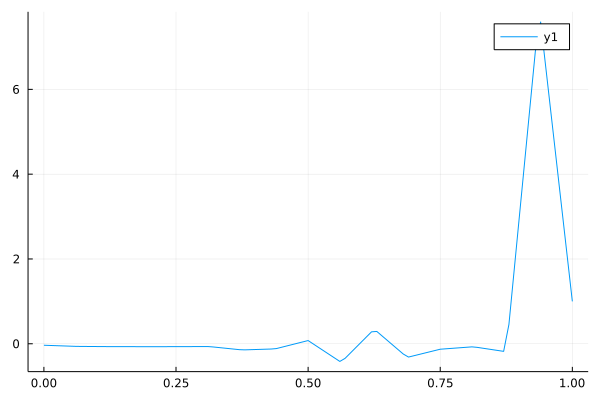

In [2]:
ADR_galerkin(16, 1., 1., [0,1])


1D Uniform Mesh: [0.0, 0.5, 1.0] with spacing: 0.5

Coefficients: [-1.3340399315380262 2.197262639300509]


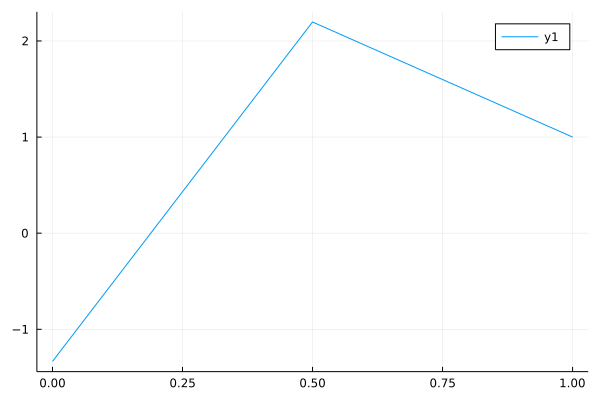

In [3]:
ADR_galerkin(2, 1., 1., [0,1])


1D Uniform Mesh: [0.0, 0.25, 0.5, 0.75, 1.0] with spacing: 0.25

Coefficients: [-0.25064242054704267 -0.5311594785594013 -0.5566201405912019 3.038024779276678]


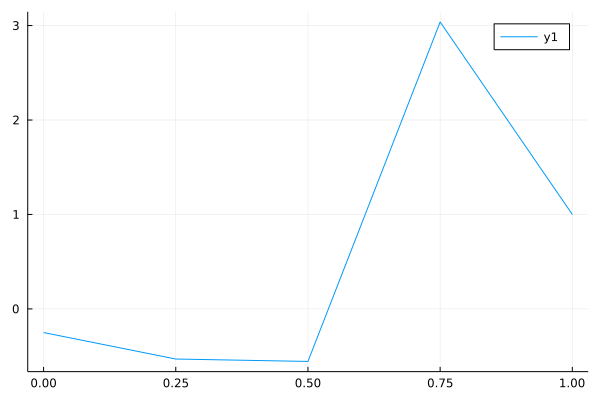

In [4]:
ADR_galerkin(4, 1., 1., [0,1])

In [5]:
ADR_galerkin(8, 1, 1, [0,1])

LoadError: MethodError: no method matching ADR_galerkin(::Int64, ::Int64, ::Int64, ::Vector{Int64})
[0mClosest candidates are:
[0m  ADR_galerkin(::Int64, [91m::Float64[39m, [91m::Float64[39m, ::Any) at In[1]:112

In [6]:
ADR_galerkin(16, 1, 1, [0,1])

LoadError: MethodError: no method matching ADR_galerkin(::Int64, ::Int64, ::Int64, ::Vector{Int64})
[0mClosest candidates are:
[0m  ADR_galerkin(::Int64, [91m::Float64[39m, [91m::Float64[39m, ::Any) at In[1]:112

In [7]:
ADR_galerkin(20, 1, 1, [0,1])

LoadError: MethodError: no method matching ADR_galerkin(::Int64, ::Int64, ::Int64, ::Vector{Int64})
[0mClosest candidates are:
[0m  ADR_galerkin(::Int64, [91m::Float64[39m, [91m::Float64[39m, ::Any) at In[1]:112

In [8]:
ADR_galerkin(16, 20, 1, [0,1])

LoadError: MethodError: no method matching ADR_galerkin(::Int64, ::Int64, ::Int64, ::Vector{Int64})
[0mClosest candidates are:
[0m  ADR_galerkin(::Int64, [91m::Float64[39m, [91m::Float64[39m, ::Any) at In[1]:112

In [9]:
@variables x
t = 0:.1:1
n = 8
mesh = collect(0:(1. / (n)):1) #n+1 points for n subintervals; x1 = 0; x_n+1 = 1

function construct_k1(a, k, mesh, row, col, delta)
    #Using sym
    x, t = gausslegendre(100); #integrates from -1 to 1 but all basis functions are 0 for x < 0
    #(k*w_x*u_x) - (a*w_x*u)
    f(x) = Naprime(x, mesh, row, delta) * Naprime(x, mesh, col, delta)
    #Book example
    #f(x) = k * Naprime(x, mesh, row, delta) * Naprime(x, mesh, col, delta)# - a * Naprime(x, mesh, col, delta) * Na(x, mesh, row, delta)
    #f(x) = k * Naprime(x, mesh, row, delta) * Naprime(x, mesh, col, delta) - a * Na(x, mesh, row, delta) * Naprime(x, mesh, col, delta)
    I = dot(t, f.(x));
    return I
end

function construct_ktot(a, k, mesh, numrow, numcol, delta)
    KMat = zeros(numrow, numcol)
    for i = 1:numrow
        for j = 1:numcol
            KMat[i, j] = construct_K_elem(a, k, mesh, i, j, delta)
        end
    end
    return KMat
end

Kmat = construct_ktot(1,1,mesh, n, n, 1. / n)

8×8 Matrix{Float64}:
  8.48181  -7.48408   0.0       0.0      …   0.0       0.0       0.0
 -8.48181  15.8433   -7.37702   0.0          0.0       0.0       0.0
  0.0      -8.35917  15.5047   -7.17642      0.0       0.0       0.0
  0.0       0.0      -8.12766  16.73         0.0       0.0       0.0
  0.0       0.0       0.0      -9.55356     -7.61311   0.0       0.0
  0.0       0.0       0.0       0.0      …  15.2402   -6.7267    0.0
  0.0       0.0       0.0       0.0         -7.62707  15.3388   -7.60072
  0.0       0.0       0.0       0.0          0.0      -8.61211  16.1895


1D Uniform Mesh: [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0] with spacing: 0.125


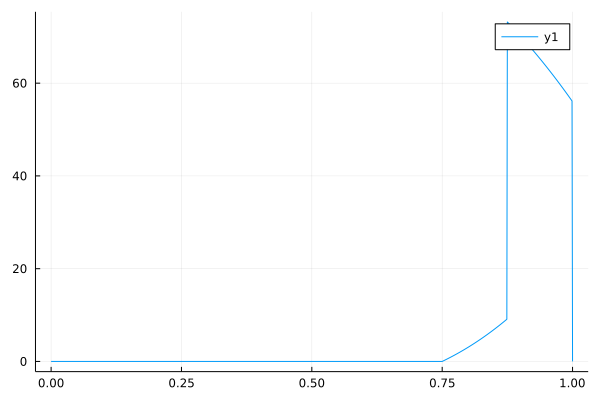

In [10]:
n = 8
delta = 1. / 8
@variables x
t = 0:.001:1
mesh = collect(0:(1. / (n)):1) #n+1 points for n subintervals; x1 = 0; x_n+1 = 1
print("\n1D Uniform Mesh: ", mesh, " with spacing: ", 1. / n, "\n")
f(x, y::Int) = Na(x, mesh, y, delta) * 12*x^2 + 1*Naprime(x, mesh, y, delta)*Nmax(x, mesh, delta) - 1*Naprime(x, mesh, y, delta)*Nmaxprime(x, mesh, delta)
max(x) = Nmax(x, mesh, delta)
sum = zeros(length(t))
for i=1:1:8
    sum+=f.(t, i)
end
plot(t, f.(t, 8))